In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import stlstuff as sls

In [58]:
%matplotlib notebook

This code solves the partial differential equation  

${\partial h \over \partial t}=D ({\partial^2 h \over \partial y^2}+{\partial^2 h \over \partial x^2})+U(x,y,t) $

where $U$ provides for sudden, initially localized growth at random locations on the facet surface.

These are two functions that flatten and deflatten functions. The first is to be able to flatten the function $U$ into 1-dimension and the second function is to unflatten $U$ back into 2-dimensions after odeint is run

In [59]:
def flatten(u):
    Nx, Ny = np.shape(u)
    return np.reshape(u, Nx*Ny)
def unflatten(uflat, Nx, Ny):
    return np.reshape(uflat, (Nx, Ny))

This function takes a flat function $U$, unflattens it, runs it through odefunc, and then flattens the result

In [60]:
def odefuncflat(uflat, t, params):
    Nx = params[2]
    Ny = params[3]
    u = unflatten(uflat, Nx, Ny)
    
    du=odefunc(u, t, params)
    duflat = flatten(du)
    return duflat 

This function takes an input of the 2-dimensional function $U$, and then computes the inner mesh points with periodic boundary conditions then computes the outermost mesh points for both x and y and then combines the results and returns $dU$

So in a sense it creates the ${\partial h \over \partial t}=D ({\partial^2 h \over \partial y^2}+{\partial^2 h \over \partial x^2})$

In [61]:
def odefunc(u, t, params):
    
    Nx,Ny = np.shape(u)
    dux = np.zeros((Nx, Ny))
    duy = np.zeros((Nx, Ny))
    du = np.zeros((Nx, Ny))
    
    Fx = params[0]
    Fy = params[1]
    
  # Compute u at inner mesh points
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
                #This takes care of the inner part of the 2D array but does not yet account for all periodic boundry condiitons
                
                dux[i, j] = (u[i-1, j] - 2*u[i, j] + u[i+1, j])*Fx
                duy[i, j] = (u[i, j-1] - 2*u[i, j] + u[i, j+1])*Fy
            
                
                
  # Compute u for top and bottom in x mesh points
    for j in range(1, Ny-1):
        duy[0, j]=(u[0, j-1] - 2*u[0, j] + u[0, j+1])*Fy
        duy[-1, j]=(u[-1, j-1] - 2*u[-1, j] + u[-1, j+1])*Fy
        
        dux[0, j]=(u[-1, j] - 2*u[0, j] + u[1, j])*Fx
        dux[-1, j]=(u[-2, j] - 2*u[-1, j] + u[0, j])*Fx
        
    #compute u for left and right in y mesh points
    for i in range(1, Nx-1):
        dux[i, 0]=(u[i-1,0] - 2*u[i, 0] + u[i+1, 0])*Fx
        dux[i, -1]=(u[i-1, -1] - 2*u[i, -1] + u[i+1, -1])*Fx
        
        duy[i, 0]=(u[i, -1] - 2*u[i, 0] + u[i, 1])*Fy
        duy[i, -1]=(u[i, -2] - 2*u[i, -1] + u[i, 0])*Fy
        
    #compute the left top corner of grid
    dux[0,0]=(u[-1,0] - 2*u[0, 0] + u[1, 0])*Fx
    duy[0,0]=(u[0,-1] - 2*u[0, 0] + u[0, 1])*Fy
    
    #compute the left bottom corner of grid
    dux[-1,0]=(u[-2,0] - 2*u[-1, 0] + u[0, 0])*Fx
    duy[-1,0]=(u[-1,-1] - 2*u[-1, 0] + u[-1, 1])*Fy
    
    #compute the right top corner of grid
    dux[0,-1]=(u[-1,-1] - 2*u[0, -1] + u[1, -1])*Fx
    duy[0,-1]=(u[0,-2] - 2*u[0, -1] + u[0, 0])*Fy
    
    #compute the right bottom corner of grid
    dux[-1,-1]=(u[-2,-1] - 2*u[-1, -1] + u[0, -1])*Fx
    duy[-1,-1]=(u[-1,-2] - 2*u[-1, -1] + u[-1, 0])*Fy

    #combine dux and duy values
    du = dux + duy

    return du

In [62]:
#parameters
L = 100
T = 10
dT = 2

#determines size of two-dimensional array
Nx = 20
Ny = 20

x = np.linspace(0, L, Nx) # mesh points in space
y = np.linspace(0, L, Ny) 

dx = x[1] - x[0]
dy = y[1] - y[0]

t = np.arange(0, T, dT) # mesh points in time

a_old = 0.00002
a = a_old*L**2

Fx = a/dx**2
Fy = a/dy**2

# Bundle parameters for ODE solver
params = [Fx,Fy, Nx, Ny]
 
# Initialize u
u = np.zeros((Nx, Ny))

# Add initial bump at midx,midy spike and integrate up to T
midx = int(Nx/2); 
midy = int(Ny/2); 
u[midx,midy] = 1

In [108]:
#add spike
#bump = (1/(4*3.1415*a))*np.exp(-(x**2+y**2)/(4*a*1))
bump = 1.1
#print(bump)
xspike = 2*L/3
yspike = 2*L/3
ixspike = int(xspike/L*Nx); 
iyspike = int(yspike/L*Ny); 
u[ixspike, iyspike]+=bump

bump = 1
xspike = .45*L
yspike = .45*L
ixspike = int(xspike/L*Nx);
iyspike = int(yspike/L*Ny);
u[ixspike, iyspike]+=bump

bump = 1.3
xspike = .93*L
yspike = .93*L
ixspike = int(xspike/L*Nx); 
iyspike = int(yspike/L*Ny);
u[ixspike, iyspike]+=bump


In [97]:
#test of flattening U and runs it through odefunc and then deflattening
uflat = flatten(u)
duflat = odefuncflat(uflat, t, params)
dutest = unflatten(duflat, Nx, Ny)
#print(dutest)

In [98]:
#runs through flattened U in odeinto and produces flat solutions that need to be unflattened individually
solflat = odeint(odefuncflat, uflat, t, args = (params,))
np.shape(solflat)

(5, 400)

In [101]:
#the first and last solutions unflattened
sol1 = unflatten(solflat[0], Nx, Ny)
sollast = unflatten(solflat[-1], Nx, Ny)

#print(np.shape(sol1))

#solss = np.zeros(np.shape(sol1))

#print(np.shape(solss))
      
#for i in range(0,-1):
    solss[i] = unflatten(solflat[i], Nx, Ny)
    

IndentationError: unexpected indent (<ipython-input-101-155da1716013>, line 12)

<IPython.core.display.Javascript object>


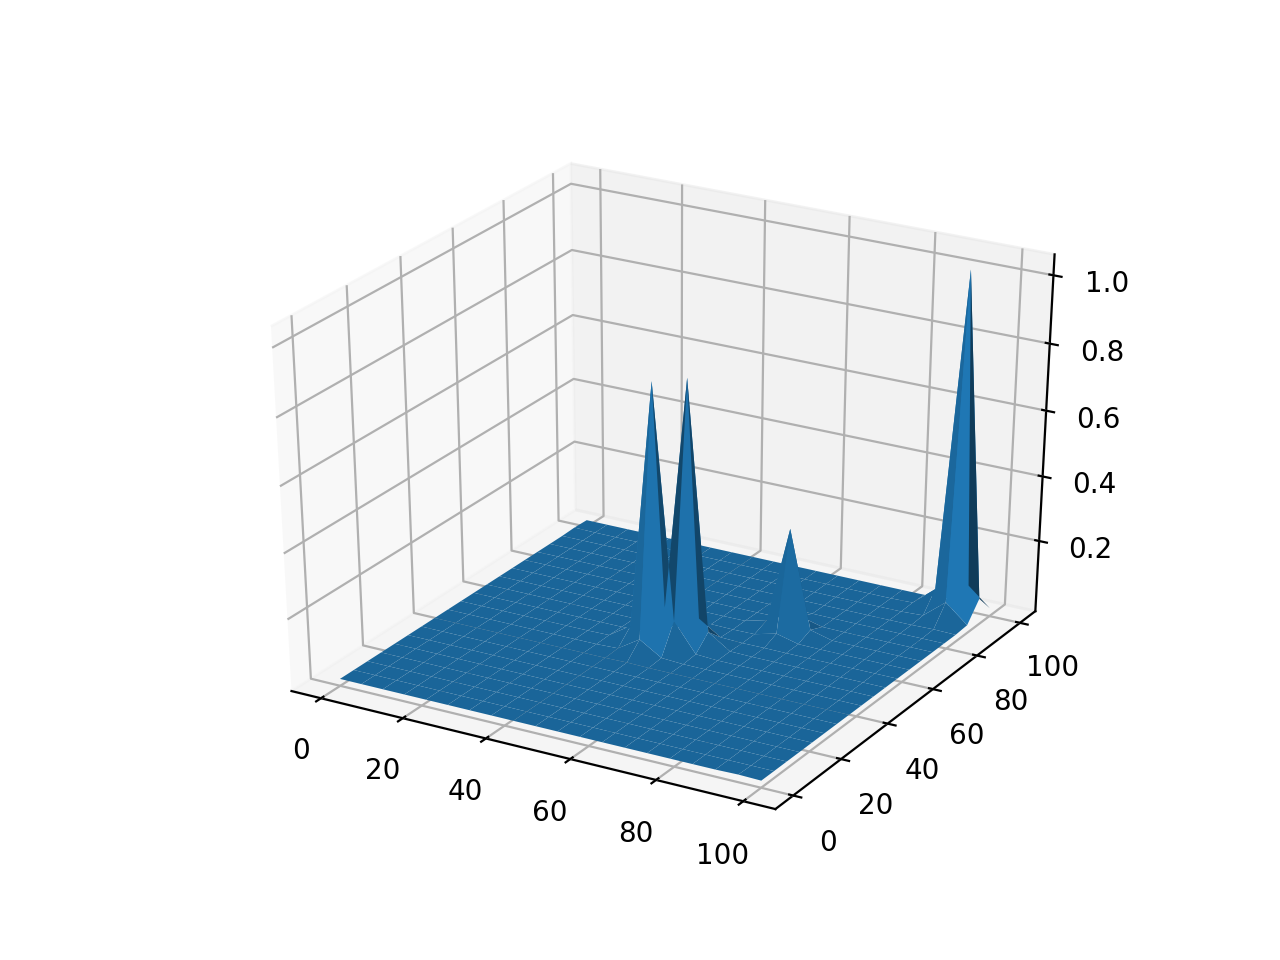

In [102]:
#graph of the last solution
xgrid, ygrid = np.meshgrid(x, y)
ax = plt.figure().gca(projection='3d')
ax.plot_surface(xgrid, ygrid, sollast)

In [68]:
#check on conservation
np.sum(sollast)

3.6978990927900686

In [69]:
#saves an individual solution as a stl file
sls.numpy2stl(sollast, "sollast.stl", scale = dx, solid=False)
#sls.numpy2stl(sollast, "sollast.stl", solid=False)

Creating top mesh...
